In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Removing missing value & read Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/2019_Nov_customer_purchase_predict_sample_large.csv'

df = pd.read_csv(file_path, header=0)


#EDA

In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:03 UTC,view,16700260,2053013559901684381,furniture.kitchen.chair,NaN,31.64,566255262,173d7b72-1db7-4638-8207-be8148bf3c9f
1,2019-11-01 00:00:04 UTC,view,34600011,2060981320581906480,NaN,NaN,20.54,512416379,4dfe2c67-e537-4dc2-ae69-0b65263db091
2,2019-11-01 00:00:11 UTC,view,41100055,2090228413959766319,NaN,NaN,38.07,562234311,4cbd502f-b1df-4bcf-a1cb-78bb18c37e70
3,2019-11-01 00:00:12 UTC,view,16700826,2053013559901684381,furniture.kitchen.chair,nika,47.77,566255262,173d7b72-1db7-4638-8207-be8148bf3c9f
4,2019-11-01 00:00:12 UTC,view,22700205,2053013556168753601,NaN,matrix,23.14,564599988,d67efe84-f47e-44dd-8abf-a9122c706acd


In [ ]:
df.shape

(6737044, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737044 entries, 0 to 6737043
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 462.6+ MB


In [ ]:
unique_values = {column: df[column].nunique() for column in df.columns}
unique_values

{'event_time': 2020122,
 'event_type': 3,
 'product_id': 139570,
 'category_id': 669,
 'category_code': 127,
 'brand': 3838,
 'price': 46151,
 'user_id': 369611,
 'user_session': 1373803}

In [ ]:
purchase_df = df[df['event_type'] == 'purchase']
purchase_counts = purchase_df.groupby('user_id').size().reset_index(name='purchase_count')
purchase_counts['is_repeat_buyer'] = (purchase_counts['purchase_count'] > 1).astype(int)

total_buyers = len(purchase_counts)
repeat_buyers = purchase_counts['is_repeat_buyer'].sum()
repeat_rate = repeat_buyers / total_buyers if total_buyers > 0 else 0

print(f"total_buyers：{total_buyers}")
print(f"repeat_buyers：{repeat_buyers}")
print(f"repeat_rate：{repeat_rate:.2%}")

total_buyers：44421
repeat_buyers：17038
repeat_rate：38.36%


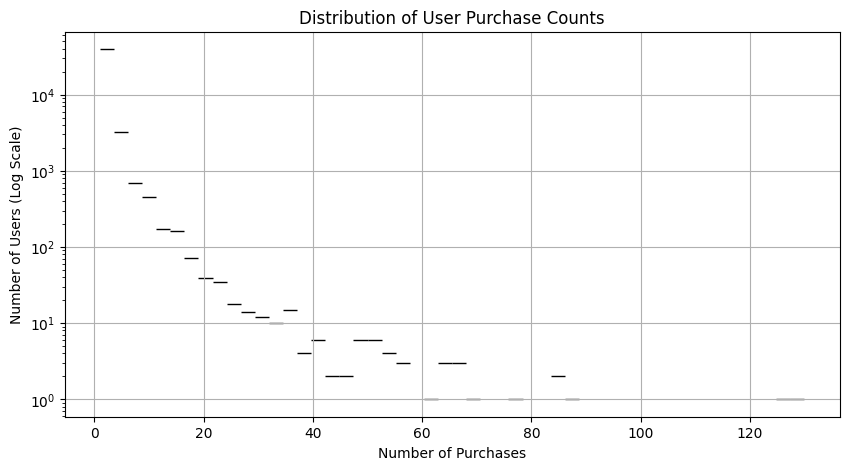

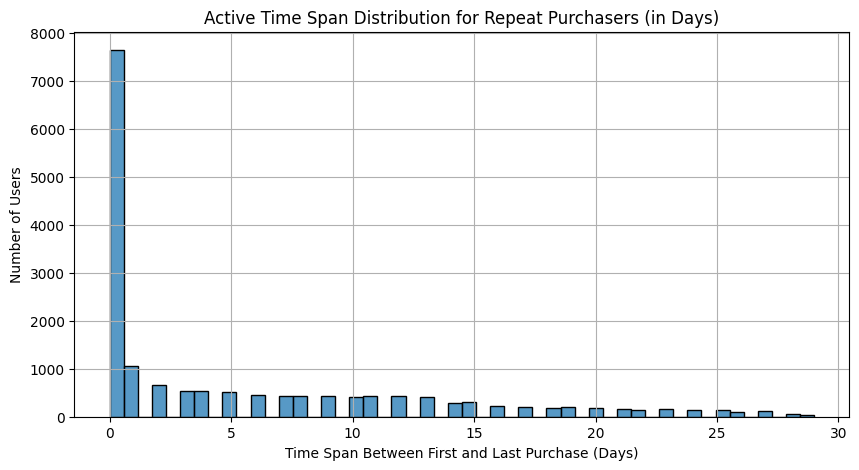

In [ ]:
df['event_time'] = pd.to_datetime(df['event_time'], utc=True)
purchase_df = df[df['event_type'] == 'purchase'].sort_values(by=['user_id', 'event_time'])

purchase_stats = purchase_df.groupby('user_id')['event_time'].agg(
    purchase_count='count',
    first_purchase='min',
    last_purchase='max'
).reset_index()

purchase_stats['active_days'] = (purchase_stats['last_purchase'] - purchase_stats['first_purchase']).dt.days

# Distribution of purchase counts
plt.figure(figsize=(10, 5))
sns.histplot(purchase_stats['purchase_count'], bins=50, log_scale=(False, True))
plt.title("Distribution of User Purchase Counts")
plt.xlabel("Number of Purchases")
plt.ylabel("Number of Users (Log Scale)")
plt.grid(True)
plt.show()

# Distribution of active time span for repeat purchasers
plt.figure(figsize=(10, 5))
sns.histplot(purchase_stats[purchase_stats['purchase_count'] > 1]['active_days'], bins=50)
plt.title("Active Time Span Distribution for Repeat Purchasers (in Days)")
plt.xlabel("Time Span Between First and Last Purchase (Days)")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()


Restructure the data
- Aggregate the data by user
- Set a forecast window: will use 10 days considering the limitation of the data time range only 30 days
- restructure the features based on RFM

In [ ]:
df['event_time'] = pd.to_datetime(df['event_time'])

end_date      = df['event_time'].max()
future_window = pd.Timedelta(days=10)
snapshot_date = end_date - future_window

df_pre  = df[df['event_time'] <  snapshot_date]
df_post = df[(df['event_time'] >= snapshot_date) & (df['event_time'] <= end_date)]


In [ ]:
user_features = pd.DataFrame({'user_id': df['user_id'].unique()}).set_index('user_id')

for evt in ['view', 'cart', 'purchase']:
    dfe = df_pre[df_pre['event_type'] == evt]

    # Recency
    last_time = dfe.groupby('user_id')['event_time'].max().rename(f'last_{evt}_time')
    user_features = user_features.join(last_time)
    user_features[f'{evt}_recency_hrs'] = (
        snapshot_date - user_features[f'last_{evt}_time']
    ).dt.total_seconds() / 3600

    # Frequency
    freq = dfe.groupby('user_id')['event_time'].count().rename(f'{evt}_frequency')
    user_features = user_features.join(freq)

    # Monetary
    mon = dfe.groupby('user_id')['price'].sum().rename(f'{evt}_monetary')
    user_features = user_features.join(mon)

    if evt == 'purchase':
        bc = dfe.groupby('user_id')['brand'].nunique().rename('purchase_brand_count')
        cc = dfe.groupby('user_id')['category_code'].nunique().rename('purchase_category_count')
        user_features = user_features.join(bc).join(cc)

user_features.head()

,last_view_time,view_recency_hrs,view_frequency,view_monetary,last_cart_time,cart_recency_hrs,cart_frequency,cart_monetary,last_purchase_time,purchase_recency_hrs,purchase_frequency,purchase_monetary,purchase_brand_count,purchase_category_count
user_id,,,,,,,,,,,,,,
566255262,2019-11-14 21:00:04+00:00,26.997222,197.0,16373.20,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
512416379,2019-11-10 20:40:25+00:00,123.324722,147.0,15333.17,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
562234311,2019-11-05 11:45:14+00:00,252.244444,16.0,1487.23,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
564599988,2019-11-01 00:00:53+00:00,359.983611,3.0,69.39,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
513200477,2019-11-02 07:34:00+00:00,328.431667,23.0,1135.39,NaT,NaN,NaN,NaN,2019-11-02 06:52:45+00:00,329.119167,1.0,33.2,1.0,1.0


In [ ]:
for col in user_features.columns:
    if col.endswith('_recency_hrs'):
        user_features[col] = user_features[col].fillna(9999)
    else:
        user_features[col] = user_features[col].fillna(0)

post_buyers = set(df_post[df_post['event_type'] == 'purchase']['user_id'])
user_features['target'] = user_features.index.to_series().isin(post_buyers).astype(int)

user_features = user_features.reset_index()
user_features.head()

,user_id,last_view_time,view_recency_hrs,view_frequency,view_monetary,last_cart_time,cart_recency_hrs,cart_frequency,cart_monetary,last_purchase_time,purchase_recency_hrs,purchase_frequency,purchase_monetary,purchase_brand_count,purchase_category_count,target
0,566255262,2019-11-14 21:00:04+00:00,26.997222,197.0,16373.20,0,9999.0,0.0,0.0,0,9999.000000,0.0,0.0,0.0,0.0,0
1,512416379,2019-11-10 20:40:25+00:00,123.324722,147.0,15333.17,0,9999.0,0.0,0.0,0,9999.000000,0.0,0.0,0.0,0.0,0
2,562234311,2019-11-05 11:45:14+00:00,252.244444,16.0,1487.23,0,9999.0,0.0,0.0,0,9999.000000,0.0,0.0,0.0,0.0,0
3,564599988,2019-11-01 00:00:53+00:00,359.983611,3.0,69.39,0,9999.0,0.0,0.0,0,9999.000000,0.0,0.0,0.0,0.0,0
4,513200477,2019-11-02 07:34:00+00:00,328.431667,23.0,1135.39,0,9999.0,0.0,0.0,2019-11-02 06:52:45+00:00,329.119167,1.0,33.2,1.0,1.0,0


# Build Pipeline

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt

# Feature Engineering
def engineer_features(df, future_window_days=10):
    df['event_time'] = pd.to_datetime(df['event_time'])
    end_date = df['event_time'].max()
    future_window = pd.Timedelta(days=future_window_days)
    snapshot_date = end_date - future_window

    df_pre = df[df['event_time'] < snapshot_date]
    df_post = df[(df['event_time'] >= snapshot_date) & (df['event_time'] <= end_date)]

    user_features = pd.DataFrame({'user_id': df['user_id'].unique()}).set_index('user_id')

    for evt in ['view', 'cart', 'purchase']:
        dfe = df_pre[df_pre['event_type'] == evt]

        last_time = dfe.groupby('user_id')['event_time'].max().rename(f'last_{evt}_time')
        user_features = user_features.join(last_time)
        user_features[f'{evt}_recency_hrs'] = (
            snapshot_date - user_features[f'last_{evt}_time']
        ).dt.total_seconds() / 3600

        freq = dfe.groupby('user_id')['event_time'].count().rename(f'{evt}_frequency')
        user_features = user_features.join(freq)

        mon = dfe.groupby('user_id')['price'].sum().rename(f'{evt}_monetary')
        user_features = user_features.join(mon)

        if evt == 'purchase':
            bc = dfe.groupby('user_id')['brand'].nunique().rename('purchase_brand_count')
            cc = dfe.groupby('user_id')['category_code'].nunique().rename('purchase_category_count')
            user_features = user_features.join(bc).join(cc)

    # View to first purchase gap feature
    gap_list = []
    for uid in df_pre['user_id'].unique():
        user_df = df_pre[df_pre['user_id'] == uid].sort_values('event_time')
        views = user_df[user_df['event_type'] == 'view']
        purchases = user_df[user_df['event_type'] == 'purchase']
        if not views.empty and not purchases.empty:
            gap = (purchases['event_time'].min() - views['event_time'].min()).total_seconds() / 3600
            gap_list.append((uid, gap))

    gap_df = pd.DataFrame(gap_list, columns=['user_id', 'view_to_purchase_gap_hrs']).set_index('user_id')
    user_features = user_features.join(gap_df)

    for col in user_features.columns:
        if col.endswith('_recency_hrs'):
            user_features[col] = user_features[col].fillna(9999)
        else:
            user_features[col] = user_features[col].fillna(0)

    post_buyers = set(df_post[df_post['event_type'] == 'purchase']['user_id'])
    user_features['target'] = user_features.index.to_series().isin(post_buyers).astype(int)

    return user_features.reset_index()


In [ ]:
def evaluate_models(data):
    X = data.drop(columns=['user_id', 'target'])
    y = data['target']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    numeric_features = X.columns.tolist()
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numeric_features)
    ])

    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
        "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.05, scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(), random_state=42)
    }

    for name, clf in models.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])
        pipe.fit(X_train, y_train)
        y_proba = pipe.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.25).astype(int)

        print(f"\n=== {name} ===")
        print(classification_report(y_test, y_pred))
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
        print(f"Avg Precision (AP): {average_precision_score(y_test, y_proba):.4f}")

        # Optional: 绘图
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
        plt.plot(recalls, precisions, label=name)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()



=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.99      0.24      0.38     71121
           1       0.05      0.93      0.09      2802

    accuracy                           0.26     73923
   macro avg       0.52      0.58      0.23     73923
weighted avg       0.95      0.26      0.37     73923

ROC AUC: 0.7262
Avg Precision (AP): 0.1264

=== RandomForest ===
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     71121
           1       0.07      0.43      0.12      2802

    accuracy                           0.76     73923
   macro avg       0.52      0.60      0.49     73923
weighted avg       0.94      0.76      0.83     73923

ROC AUC: 0.6829
Avg Precision (AP): 0.0747


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11208, number of negative: 284480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 295688, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037905 -> initscore=-3.234035
[LightGBM] [Info] Start training from score -3.234035


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== LightGBM ===
              precision    recall  f1-score   support

           0       0.99      0.35      0.52     71121
           1       0.05      0.90      0.10      2802

    accuracy                           0.37     73923
   macro avg       0.52      0.63      0.31     73923
weighted avg       0.95      0.37      0.51     73923

ROC AUC: 0.7430
Avg Precision (AP): 0.1526


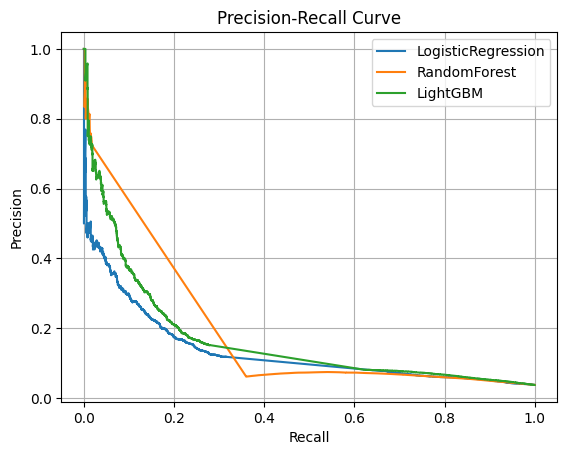

In [ ]:
# EXECUTION
features_df = engineer_features(df, future_window_days=10)
evaluate_models(features_df)

Model Ranking (Based on PR Curve)
- LightGBM: Best balance of precision and recall across a wide range.
- Logistic Regression: Simple and decent in low-recall/high-precision regions.
- Random Forest: Underperforms in both dimensions compared to the others